In [47]:
import os
import copy
import numpy as np
from scipy import signal, stats, constants
from scipy.optimize import minimize, curve_fit
import h5py as hp
import re

import matplotlib.pyplot as plt
import matplotlib as mplt
import matplotlib.gridspec as gridspec
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.axes_grid1 import make_axes_locatable

import pyproj as proj
from scipy.spatial.transform import Rotation as R

prop_cycle = plt.rcParams['axes.prop_cycle']   
colors = prop_cycle.by_key()['color']   

In [2]:
Test_LOC = {
    1:[48 + 38.644/60, 123 + 29.717/60],
    2:[48 + 38.611/60, 123 + 29.811/60],
    3:[48 + 38.614/60, 123 + 29.592/60],
    4:[48 + 38.719/60, 123 + 29.718/60],
    5:[48 + 39.138/60, 123 + 29.695/60],
    6:[48 + 38.977/60, 123 + 29.752/60],
    7:[48 + 39.199/60, 123 + 29.684/60],
    8:[48 + 39.468/60, 123 + 29.723/60]
}

Beacon_LOC = {
    2407:[48 + 38.697/60, 123 + 29.598/60],
    3008:[48 + 38.704/60, 123 + 29.821/60],
    2404:[48 + 38.571/60, 123 + 29.710/60]
}

LOC_1 = {
    'start':[48 + 38.649/60, 123 + 29.715/60],
    'mid':[48 + 38.650/60, 123 + 29.717/60],
    'end':[48 + 38.649/60, 123 + 29.717/60]
}

LOC_8 = {
    'start':[48 + 39.460/60, 123 + 29.712/60],
    'mid':[48 + 39.463/60, 123 + 29.718/60],
    'end':[48 + 39.468/60, 123 + 29.723/60]
}

In [3]:
def transform_cart(lats, longs, height):
    transformer = proj.Transformer.from_crs("+proj=latlong +datum=WGS84", "+proj=geocent +datum=WGS84")
    xyz_point = transformer.transform(longs, lats, height)
    return xyz_point

def get_rotation_info(ref_points):
    # Expects to get ref_points as 3 points which it will rotate onto xy
    #ref_points = ref_points.T
    u = ref_points[:,0] - ref_points[:,1]
    v = ref_points[:,1] - ref_points[:,2]

    n_vec = np.cross(u,v)
    norm = np.sqrt(np.dot(n_vec,n_vec))

    n_vec = n_vec/norm

    D_offset = np.dot(n_vec, ref_points[:,0])

    rot_vec = np.cross(n_vec, np.array([0,0,1]))

    rot_vec = rot_vec/(np.sqrt(np.dot(rot_vec,rot_vec)))

    rot_angle_theta = np.arccos(n_vec[2]) - np.pi
    rot_angle_phi = np.arctan(n_vec[1]/n_vec[0])
    
    return rot_vec, n_vec, D_offset, rot_angle_phi, rot_angle_theta

def arrow(x,y,ax,n):
    d = len(x)//(n+1)    
    ind = np.arange(d,len(x),d)
    for i in ind:
        ar = FancyArrowPatch ((x[i-1],y[i-1]),(x[i],y[i]), 
                              arrowstyle='->', mutation_scale=20)
        ax.add_patch(ar)

In [4]:
beacon_cart = np.zeros((3,3))
test_cart = np.zeros((3,8))
loc1_cart = np.zeros((3,3))
loc8_cart = np.zeros((3,3))

for i, key in enumerate(list(Beacon_LOC.keys())):
    beacon_cart[:,i] = transform_cart(Beacon_LOC[key][0], Beacon_LOC[key][1], -165)
    
for i, key in enumerate(list(Test_LOC.keys())):
    test_cart[:,i] = transform_cart(Test_LOC[key][0], Test_LOC[key][1], 0)
    
for i, key in enumerate(list(LOC_1.keys())):
    loc1_cart[:,i] = transform_cart(LOC_1[key][0], LOC_1[key][1], 0)
    
for i, key in enumerate(list(LOC_1.keys())):
    loc8_cart[:,i] = transform_cart(LOC_8[key][0], LOC_8[key][1], 0)
    
middle_of_beacons = np.mean(beacon_cart, axis=1)

beacon_cart = (beacon_cart.T - middle_of_beacons).T
test_cart = (test_cart.T - middle_of_beacons).T
loc1_cart = (loc1_cart.T - middle_of_beacons).T
loc8_cart = (loc8_cart.T - middle_of_beacons).T

rot_vec, n_vec, D_offset, rot_angle_phi, rot_angle_theta = get_rotation_info(beacon_cart)


In [5]:
rot = R.from_rotvec(rot_angle_theta*rot_vec)
rot_p = np.dot(rot.as_matrix(), beacon_cart)
rot_locs = np.dot(rot.as_matrix(), test_cart)
rot_loc1 = np.dot(rot.as_matrix(), loc1_cart)
rot_loc8 = np.dot(rot.as_matrix(), loc8_cart)

<IPython.core.display.Javascript object>


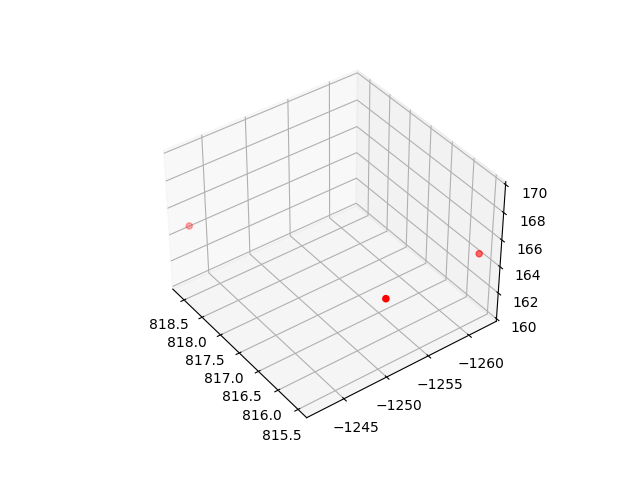

[[  818.59394474   815.51868063   815.51303899]
 [-1242.17845    -1250.88095417 -1261.99702765]
 [  164.82809063   164.8267858    164.8245966 ]]


In [6]:
%matplotlib notebook


fig = plt.figure()
ax = fig.add_subplot(projection='3d')

#ax.scatter(rot_p[0], rot_p[1], rot_p[2], color='blue', label='Beacons')
#ax.scatter(rot_locs[0][0], rot_locs[1][0], rot_locs[2][0], color='red')
#ax.scatter(rot_loc1[0], rot_loc1[1], rot_loc1[2], color='green')
ax.scatter(rot_loc8[0], rot_loc8[1], rot_loc8[2], color='red')


print(rot_loc8)

ax.set_zlim((160, 170))
plt.show()

In [34]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = mplt.colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

In [52]:
cmap = plt.get_cmap('viridis')
new_range = [int(i*100/cmap.N) for i in range(cmap.N)]
colors_new = [cmap(i) for i in new_range]

def plot_recos(infile, ax, label, marker='o'):
    hfile = hp.File(infile, 'r')
    samplers = list(hfile.keys())
    
    for i, sampler in enumerate(samplers):
        elements = list(hfile[sampler]['labels'])                                                                                                             
        elements = [x.decode('utf-8') for x in elements]                                                                                                      
        x_index = elements.index('xr[0, 0]')                                                                                                                  
        y_index = elements.index('xr[1, 0]')                                                                                                                  
        z_index = elements.index('xr[2, 0]') 
        means = hfile[sampler]['means']                                                                                                                       
        x_value = means[x_index]                                                                                                                              
        y_value = means[y_index]                                                                                                                              
        z_value = means[z_index]       
        r = np.array([x_value, y_value, z_value])
        print(f'Sampler: {sampler}')
        print(f'Position: {r}')
        ax.plot(x_value, y_value, label=label + sampler, marker=marker, linestyle='', alpha=0.5, color=colors_new[i]) #, color=colors[i]
    
    hfile.close()
    return 0


def plot_loops(infile, ax, label, marker='o'):
    hfile = hp.File(infile, 'r')
    samplers = list(hfile.keys())
    samplers = [x for x in samplers if 'NUTS' in x]
    
    for i, sampler in enumerate(samplers):
        elements = list(hfile[sampler]['labels'])                                                                                                             
        elements = [x.decode('utf-8') for x in elements]                                                                                                      
        x_index = elements.index('xr[0, 0]')                                                                                                                  
        y_index = elements.index('xr[1, 0]')                                                                                                                  
        z_index = elements.index('xr[2, 0]') 
        means = hfile[sampler]['means']                                                                                                                       
        x_value = means[x_index]                                                                                                                              
        y_value = means[y_index]                                                                                                                              
        z_value = means[z_index]                                                                                                                                                                                                                                                                
        r = np.array([x_value, y_value, z_value])
        print(f'Sampler: {sampler}')
        print(f'Position: {r}')
        ax.plot(x_value, y_value, label=label + sampler, marker=marker, linestyle='', color=colors[i], alpha=0.5)
    
    hfile.close()
    return 0


def plot_full_recos(infile, ax, label, marker='o'):
    hfile = hp.File(infile, 'r')
    samplers = list(hfile.keys())
    numbers = np.array([int(re.findall(r'\d+', s)[0]) for s in samplers])
    sorted_indices = np.argsort(numbers)
    samplers = np.array(samplers)[sorted_indices]
    
    for i, sampler in enumerate(samplers):
        elements = list(hfile[sampler]['labels'])                                                                                                             
        elements = [x.decode('utf-8') for x in elements]                                                                                                      
        x_index = elements.index('xr[0, 0]')                                                                                                                  
        y_index = elements.index('xr[1, 0]')                                                                                                                  
        z_index = elements.index('xr[2, 0]') 
        means = hfile[sampler]['means']                                                                                                                       
        x_value = means[x_index]                                                                                                                              
        y_value = means[y_index]                                                                                                                              
        z_value = means[z_index]       
        if x_value < 800:
            continue
        r = np.array([x_value, y_value, z_value])
        print(f'Sampler: {sampler}')
        print(f'Position: {r}')
        ax.plot(x_value, y_value, label=label + sampler, marker=marker, linestyle='', alpha=0.5, color=colors_new[i]) #, color=colors[i]
    
    hfile.close()
    return 0


<IPython.core.display.Javascript object>


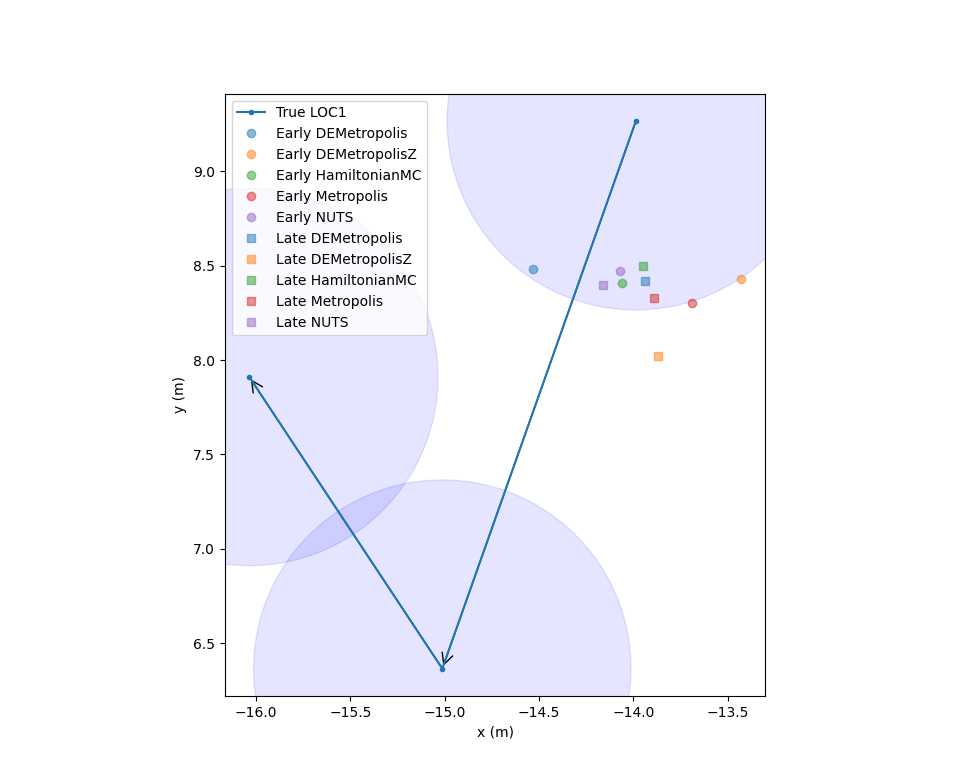

Sampler: DEMetropolis
Position: [-14.53   8.48 147.62]
Sampler: DEMetropolisZ
Position: [-13.43   8.43 149.04]
Sampler: HamiltonianMC
Position: [-14.06   8.41 147.59]
Sampler: Metropolis
Position: [-13.69   8.3  145.31]
Sampler: NUTS
Position: [-14.07   8.47 147.38]
Sampler: DEMetropolis
Position: [-13.94   8.42 145.66]
Sampler: DEMetropolisZ
Position: [-13.87   8.02 144.91]
Sampler: HamiltonianMC
Position: [-13.95   8.5  144.74]
Sampler: Metropolis
Position: [-13.89   8.33 144.89]
Sampler: NUTS
Position: [-14.16   8.4  144.8 ]


In [25]:
fig = plt.figure()
ax = fig.add_subplot()

for i in range(3):
    circle = plt.Circle((rot_loc1[0][i], rot_loc1[1][i]), 1, color='blue', alpha=0.1)
    ax.add_artist(circle)

ax.plot(rot_loc1[0], rot_loc1[1], label='True LOC1', marker='.')

#ax.plot(rot_locs[0][0], rot_locs[1][0], marker='x', linestyle='', label='old boat position')
arrow(rot_loc1[0], rot_loc1[1], ax, 2)

early_file = '/home/dilraj/Programs/ocean_test/data/rev4/ANALYSIS/SAANICH/posterior/loc1_ch1ch2_early.hdf5'
late_file = '/home/dilraj/Programs/ocean_test/data/rev4/ANALYSIS/SAANICH/posterior/loc1_ch1ch2_late.hdf5'
plot_recos(early_file, ax, label='Early ', marker='o')
plot_recos(late_file, ax, label='Late ', marker='s')

ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')
ax.set_aspect((1))

plt.legend()
plt.show()

<IPython.core.display.Javascript object>


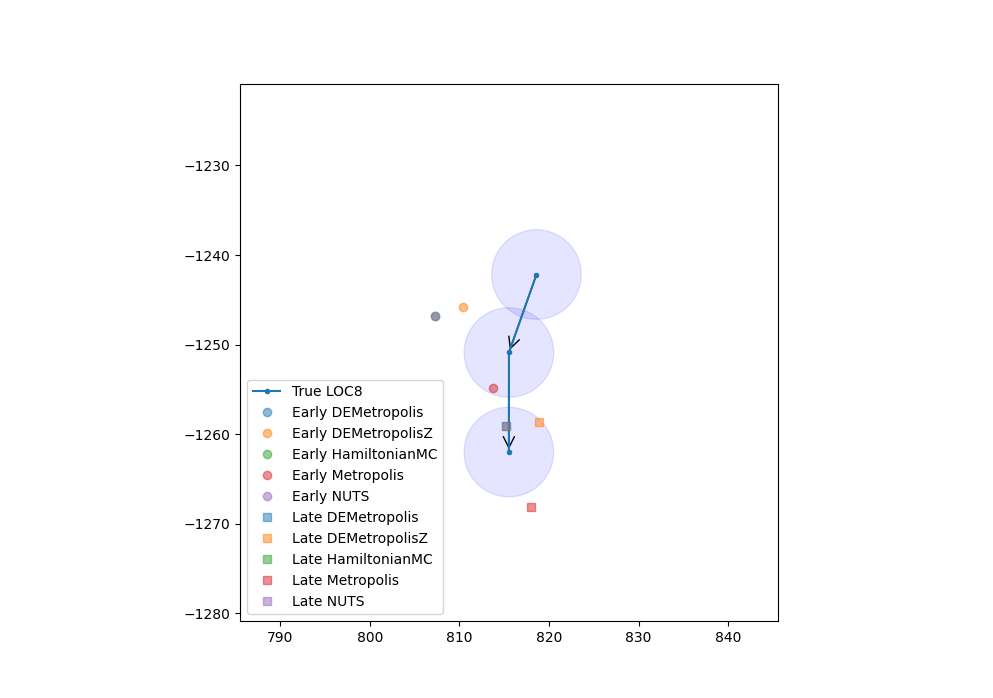

Sampler: DEMetropolis
Position: [  719.52 -1115.38   182.2 ]
Sampler: DEMetropolisZ
Position: [  810.41 -1245.8    146.13]
Sampler: HamiltonianMC
Position: [  807.32 -1246.86   145.48]
Sampler: Metropolis
Position: [  813.71 -1254.81   145.84]
Sampler: NUTS
Position: [  807.27 -1246.86   145.47]
Sampler: DEMetropolis
Position: [  734.34 -1240.34   229.82]
Sampler: DEMetropolisZ
Position: [  818.86 -1258.66   148.06]
Sampler: HamiltonianMC
Position: [  815.14 -1259.08   146.85]
Sampler: Metropolis
Position: [  817.93 -1268.12   148.66]
Sampler: NUTS
Position: [  815.15 -1259.04   146.84]


In [22]:
fig = plt.figure()
ax = fig.add_subplot()

ax.plot(rot_loc8[0], rot_loc8[1], label='True LOC8', marker='.')

for i in range(3):
    circle = plt.Circle((rot_loc8[0][i], rot_loc8[1][i]), 5, color='blue', alpha=0.1)
    ax.add_artist(circle)
#ax.plot(rot_locs[0][0], rot_locs[1][0], marker='x', linestyle='', label='old boat position')
arrow(rot_loc8[0], rot_loc8[1], ax, 2)

early_file = '/home/dilraj/Programs/ocean_test/data/rev4/ANALYSIS/SAANICH/posterior/loc8_ch1ch2_early.hdf5'
late_file = '/home/dilraj/Programs/ocean_test/data/rev4/ANALYSIS/SAANICH/posterior/loc8_ch1ch2_late.hdf5'
plot_recos(early_file, ax, label='Early ', marker='o')
plot_recos(late_file, ax, label='Late ', marker='s')

ax.set_xlim((rot_loc8[0][1] - 30, rot_loc8[0][1] + 30))
ax.set_ylim((rot_loc8[1][1] - 30, rot_loc8[1][1] + 30))
ax.set_aspect((1))
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


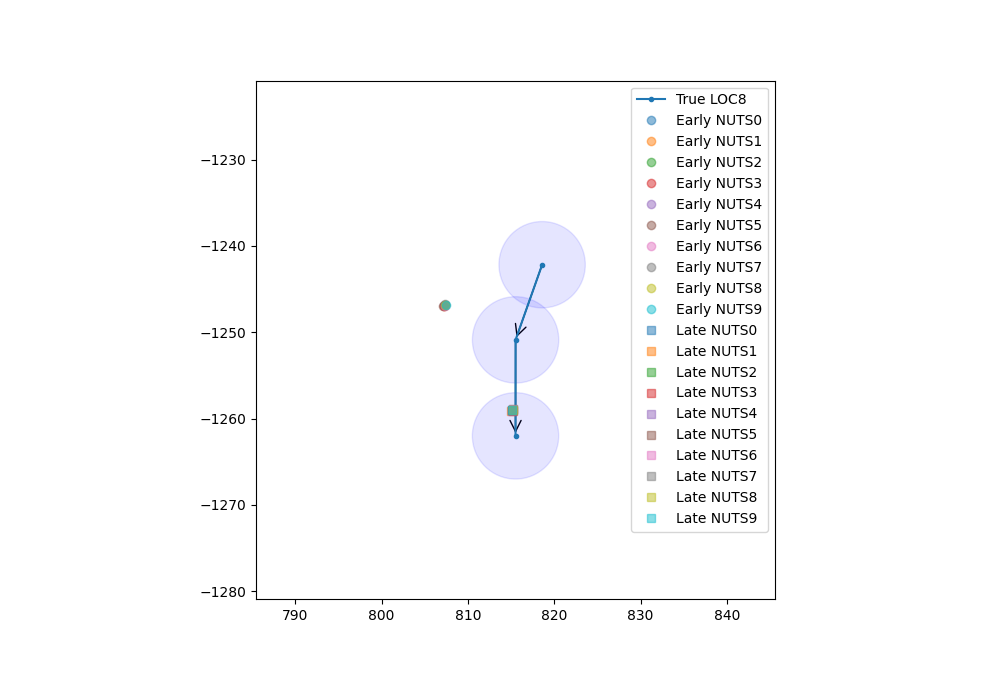

Sampler: NUTS0
Position: [  807.34 -1246.89   145.38]
Sampler: NUTS1
Position: [  807.2  -1246.99   145.35]
Sampler: NUTS2
Position: [  807.36 -1246.82   145.29]
Sampler: NUTS3
Position: [  807.18 -1246.99   145.5 ]
Sampler: NUTS4
Position: [  807.19 -1246.87   145.62]
Sampler: NUTS5
Position: [  807.14 -1246.97   145.49]
Sampler: NUTS6
Position: [  807.31 -1246.93   145.48]
Sampler: NUTS7
Position: [  807.29 -1246.76   145.45]
Sampler: NUTS8
Position: [  807.31 -1246.88   145.52]
Sampler: NUTS9
Position: [  807.42 -1246.9    145.48]
Sampler: NUTS0
Position: [  815.05 -1259.05   147.02]
Sampler: NUTS1
Position: [  814.98 -1259.17   147.08]
Sampler: NUTS2
Position: [  815.23 -1258.88   146.99]
Sampler: NUTS3
Position: [  815.26 -1259.08   146.91]
Sampler: NUTS4
Position: [  815.16 -1259.06   146.83]
Sampler: NUTS5
Position: [  815.13 -1259.04   146.94]
Sampler: NUTS6
Position: [  815.27 -1258.84   146.74]
Sampler: NUTS7
Position: [  815.23 -1259.05   146.73]
Sampler: NUTS8
Position: [  

In [23]:
fig = plt.figure()
ax = fig.add_subplot()

ax.plot(rot_loc8[0], rot_loc8[1], label='True LOC8', marker='.')
#ax.plot(rot_locs[0][0], rot_locs[1][0], marker='x', linestyle='', label='old boat position')
arrow(rot_loc8[0], rot_loc8[1], ax, 2)

for i in range(3):
    circle = plt.Circle((rot_loc8[0][i], rot_loc8[1][i]), 5, color='blue', alpha=0.1)
    ax.add_artist(circle)

early_file = '/home/dilraj/Programs/ocean_test/data/rev4/ANALYSIS/SAANICH/posterior/looping_seed_early.hdf5'
late_file = '/home/dilraj/Programs/ocean_test/data/rev4/ANALYSIS/SAANICH/posterior/looping_seed_late.hdf5'
plot_loops(early_file, ax, label='Early ', marker='o')
plot_loops(late_file, ax, label='Late ', marker='s')

ax.set_xlim((rot_loc8[0][1] - 30, rot_loc8[0][1] + 30))
ax.set_ylim((rot_loc8[1][1] - 30, rot_loc8[1][1] + 30))
ax.set_aspect((1))
plt.legend()

plt.show()

<IPython.core.display.Javascript object>


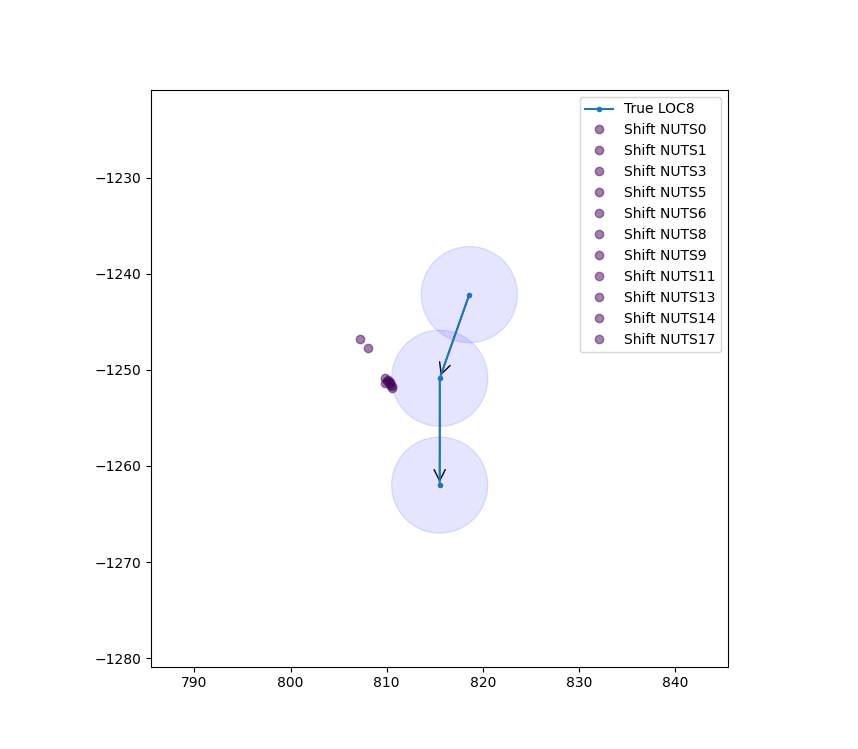

Sampler: NUTS0
Position: [  807.2  -1246.83   145.54]
Sampler: NUTS1
Position: [  809.79 -1250.84   145.79]
Sampler: NUTS3
Position: [  810.04 -1251.19   145.98]
Sampler: NUTS5
Position: [  810.33 -1251.32   145.98]
Sampler: NUTS6
Position: [  810.38 -1251.34   145.99]
Sampler: NUTS8
Position: [  808.07 -1247.74   145.45]
Sampler: NUTS9
Position: [  809.84 -1251.35   146.11]
Sampler: NUTS11
Position: [  810.09 -1251.1    146.02]
Sampler: NUTS13
Position: [  810.37 -1251.59   145.91]
Sampler: NUTS14
Position: [  810.51 -1251.92   146.04]
Sampler: NUTS17
Position: [  810.57 -1251.66   145.87]


In [53]:
fig = plt.figure()
ax = fig.add_subplot()

ax.plot(rot_loc8[0], rot_loc8[1], label='True LOC8', marker='.')
#ax.plot(rot_locs[0][0], rot_locs[1][0], marker='x', linestyle='', label='old boat position')
arrow(rot_loc8[0], rot_loc8[1], ax, 2)

for i in range(3):
    circle = plt.Circle((rot_loc8[0][i], rot_loc8[1][i]), 5, color='blue', alpha=0.1)
    ax.add_artist(circle)

early_file = '/home/dilraj/Programs/ocean_test/data/rev4/ANALYSIS/SAANICH/posterior/sample_data.hdf5'
plot_full_recos(early_file, ax, label='Shift ', marker='o')

ax.set_xlim((rot_loc8[0][1] - 30, rot_loc8[0][1] + 30))
ax.set_ylim((rot_loc8[1][1] - 30, rot_loc8[1][1] + 30))
ax.set_aspect((1))
plt.legend()

plt.show()